In [14]:
using Pkg
Pkg.activate("@__DIR__")
Pkg.instantiate()

using DataFrames
using Plots
using CategoricalArrays
using Random
using Imbalance
using MLJBase: machine, transform
using ScientificTypes
using TableTransforms
using CSV
using DataFrames

### 1. Generate Random Data

In [15]:
rng = Random.default_rng()


num_rows = 100
num_cont_feats = 0
probs = [0.5, 0.2, 0.3]

cat_feats_num_vals = [3, 4, 2, 5]

X, y = generate_imbalanced_data(num_rows, num_cont_feats; probs, cat_feats_num_vals)
X = DataFrame(X)

X = coerce(X, autotype(X, :few_to_finite))

Row,Column1,Column2,Column3,Column4
,Cat…,Cat…,Cat…,Cat…
1,1,3,2,5
2,1,2,2,3
3,2,3,2,4
4,2,4,1,1
5,1,4,2,4
6,1,1,1,5
7,2,1,2,5
8,2,3,1,2
9,2,3,2,3


### 2. Apply SMOTE-N

#### Using Imbalance Only

In [16]:
Xover, yover = smoten(X, y; k = 5, ratios = Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng = 42)

(183×4 DataFrame
 Row │ Column1  Column2  Column3  Column4 
     │ Cat…     Cat…     Cat…     Cat…    
─────┼────────────────────────────────────
   1 │ 1        3        2        5
   2 │ 1        2        2        3
   3 │ 2        3        2        4
   4 │ 2        4        1        1
   5 │ 1        4        2        4
   6 │ 1        1        1        5
   7 │ 2        1        2        5
   8 │ 2        3        1        2
  ⋮  │    ⋮        ⋮        ⋮        ⋮
 177 │ 1        4        2        5
 178 │ 1        4        2        2
 179 │ 2        3        2        1
 180 │ 3        4        1        3
 181 │ 1        4        1        5
 182 │ 3        4        1        4
 183 │ 1        3        2        4
                          168 rows omitted, CategoricalValue{Int64, UInt32}[0, 0, 1, 1, 2, 0, 0, 1, 0, 1  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

#### Using MLJ

In [17]:
smotenc_model = Imbalance.MLJ.SMOTEN(k=5, ratios=Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng=42)
mach = machine(smotenc_model)
Xover, yover = transform(mach, X, y)
Xover

Row,Column1,Column2,Column3,Column4
,Cat…,Cat…,Cat…,Cat…
1,1,3,2,5
2,1,2,2,3
3,2,3,2,4
4,2,4,1,1
5,1,4,2,4
6,1,1,1,5
7,2,1,2,5
8,2,3,1,2
9,2,3,2,3


#### Using TableTransforms

In [18]:
# For TableTransforms
Xy = CSV.read("../datasets/churn.csv", DataFrame)
y_ind = 17
Xy = coerce(Xy, autotype(Xy, :string_to_multiclass))

types = schema(Xy).scitypes
cat_inds = findall( x -> x <: Finite, types)
Xy = Xy[:, cat_inds]
Xy

Row,Surname,Geography,Gender
,Cat…,Cat…,Cat…
1,Hargrave,France,Female
2,Hill,Spain,Female
3,Onio,France,Female
4,Boni,France,Female
5,Mitchell,Spain,Female
6,Chu,Spain,Male
7,Bartlett,France,Male
8,Obinna,Germany,Female
9,He,France,Male


In [19]:
using Imbalance: TableTransforms.SMOTEN
y_ind = 2
smoten_model_t = SMOTEN(y_ind, ratios=Dict(1=> 1.2, 2=>1.2, 3=>1.2, 4=>1.2), rng=42)
Xyover = Xy |> smoten_model_t

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:00



Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  class:  2


Row,Surname,Geography,Gender
,Cat…,Cat…,Cat…
1,Hargrave,France,Female
2,Hill,Spain,Female
3,Onio,France,Female
4,Boni,France,Female
5,Mitchell,Spain,Female
6,Chu,Spain,Male
7,Bartlett,France,Male
8,Obinna,Germany,Female
9,He,France,Male


### 3. Plot the Results

   Resolving package versions...


  No Changes to `~/Documents/GitHub/Imbalance.jl/Project.toml`
  No Changes to `~/Documents/GitHub/Imbalance.jl/Manifest.toml`


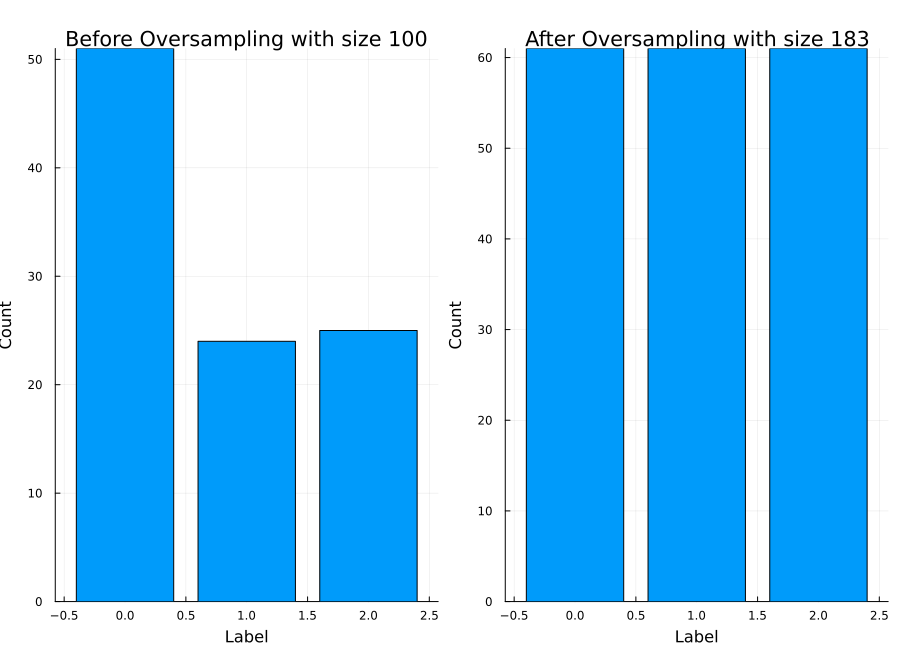

In [20]:
include("plot.jl")                      # provides a plot function to compare results
plot_data(y, yover, X, Xover, hist_only=true)